In [89]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ttest_ind
import networkx as nx
import networkit as nk
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'



In [185]:
nodes = nx.read_graphml("graphs/all.graphml").nodes()
# load G as a networkit graph
G = nk.readGraph("graphs/all.graphml", nk.Format.GraphML)

# Compute centralities
betweenness_centralities = nk.centrality.ApproxBetweenness(G).run().scores()
closeness_centralities = nk.centrality.ApproxCloseness(G, nSamples=100).run().scores()
degree_centralities = nk.centrality.DegreeCentrality(G).run().scores()


In [189]:
# Create DataFrame to store the centrality measures
centrality_df = pd.DataFrame({
    'Degree Centrality': degree_centralities,
    'Closeness Centrality': closeness_centralities,
    'Betweenness Centrality': betweenness_centralities
})

# Set the nodes as the index of the DataFrame
centrality_df.index = nodes

# Save the DataFrame to a CSV file
centrality_df.to_csv('centralities/centrality_measures.csv')

# label index as 'researcher_id'
centrality_df.index.name = 'researcher_id'
centrality_df['rank_dc'] = centrality_df['Degree Centrality'].rank(ascending=False, pct=True)
centrality_df['rank_cc'] = centrality_df['Closeness Centrality'].rank(ascending=False, pct=True)
centrality_df['rank_bc'] = centrality_df['Betweenness Centrality'].rank(ascending=False, pct=True)

# load cleaned data
clean_data = pd.read_csv('../data_light/data_clean.csv')

# merged centrality_df with clean_data for LMIC and gender columns
centrality_df = centrality_df.merge(clean_data[['researcher_id', 'LMIC', 'gender']], on='researcher_id')


In [83]:
# count gender values
centrality_df.gender.value_counts(normalize=True)

0    0.666608
1    0.333392
Name: gender, dtype: float64

In [192]:
centrality_df.head()

,researcher_id,Degree Centrality,Closeness Centrality,Betweenness Centrality,rank_dc,rank_cc,rank_bc,LMIC,gender
0,ur.01006172666.33,27.0,9.468657e-08,0.000000,0.210132,1.000000,0.580094,0,1
1,ur.01012736025.78,27.0,1.101875e-06,0.000000,0.210132,0.673914,0.580094,0,0
2,ur.010132635727.81,75.0,1.272017e-06,0.000123,0.035037,0.190813,0.038487,0,0
3,ur.010132635727.81,75.0,1.272017e-06,0.000123,0.035037,0.190813,0.038487,0,0
4,ur.01023477132.25,27.0,1.101875e-06,0.000000,0.210132,0.673914,0.580094,0,1


In [201]:
def get_top_x_percentile(column_name):

    # get the distributions of LMIC and HIC for the top x% of authors
    lmic_means = []
    female_means = []

    lmic_signficant = []
    female_signficant = []

    for i in np.arange(1, 101, 1):
        centrality_df_i = centrality_df[centrality_df[column_name] <= i/100]

        list_lmic = centrality_df_i['LMIC'].values
        avg_lmic = np.mean(list_lmic)
        pvalue = ttest_ind(centrality_df_i['LMIC'], centrality_df.LMIC)[1]

        lmic_means.append(avg_lmic)
        lmic_signficant.append(pvalue < 0.05)

        list_female = centrality_df_i['gender'].values
        avg_female = np.mean(list_female)
        pvalue = ttest_ind(centrality_df_i['gender'], centrality_df.gender)[1]

        female_means.append(avg_female)
        female_signficant.append(pvalue < 0.05)


    #th_lmic = lmic_signficant.index(0) if 0 in lmic_signficant else 100
    if 0 in lmic_signficant:
        th_lmic = lmic_signficant.index(0)
    else:
        th_lmic = 100

    if 0 in female_signficant:
        th_female = female_signficant.index(0)
    else:
        th_female = 100

    return lmic_means, th_lmic, female_means, th_female 


In [202]:
# get female and LMIC mean for the whole set
avg_lmic = centrality_df['LMIC'].mean()*100
avg_female = centrality_df['gender'].mean()*100


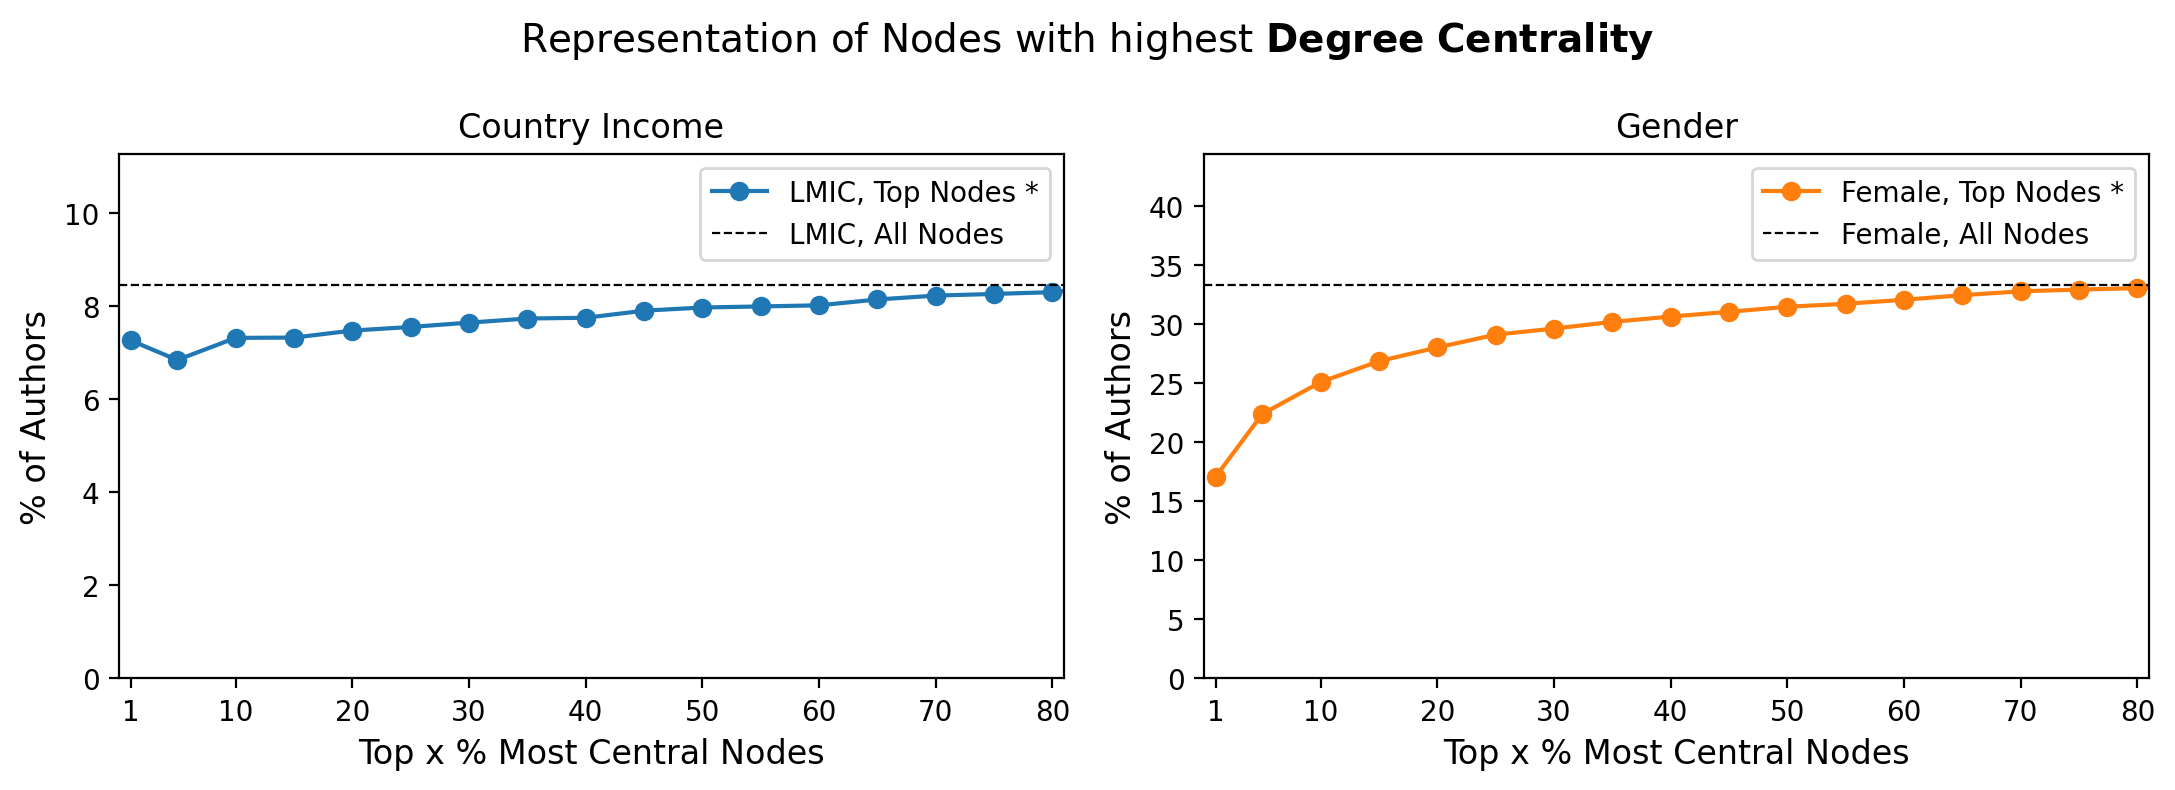

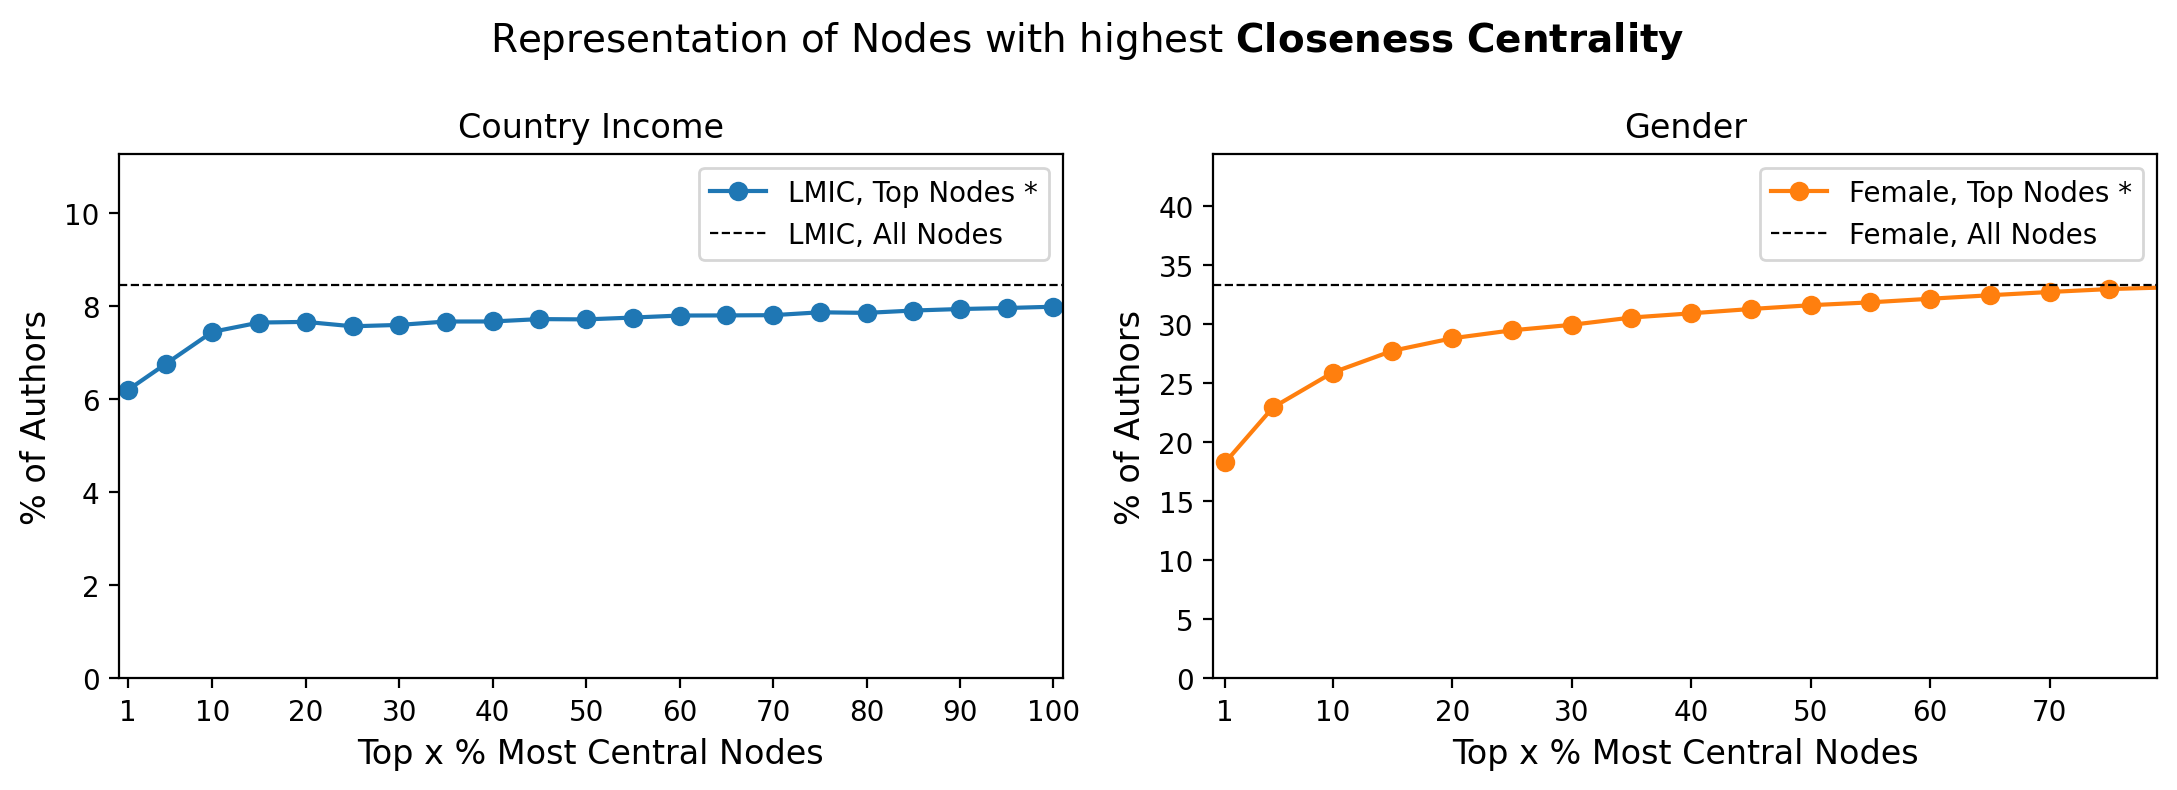

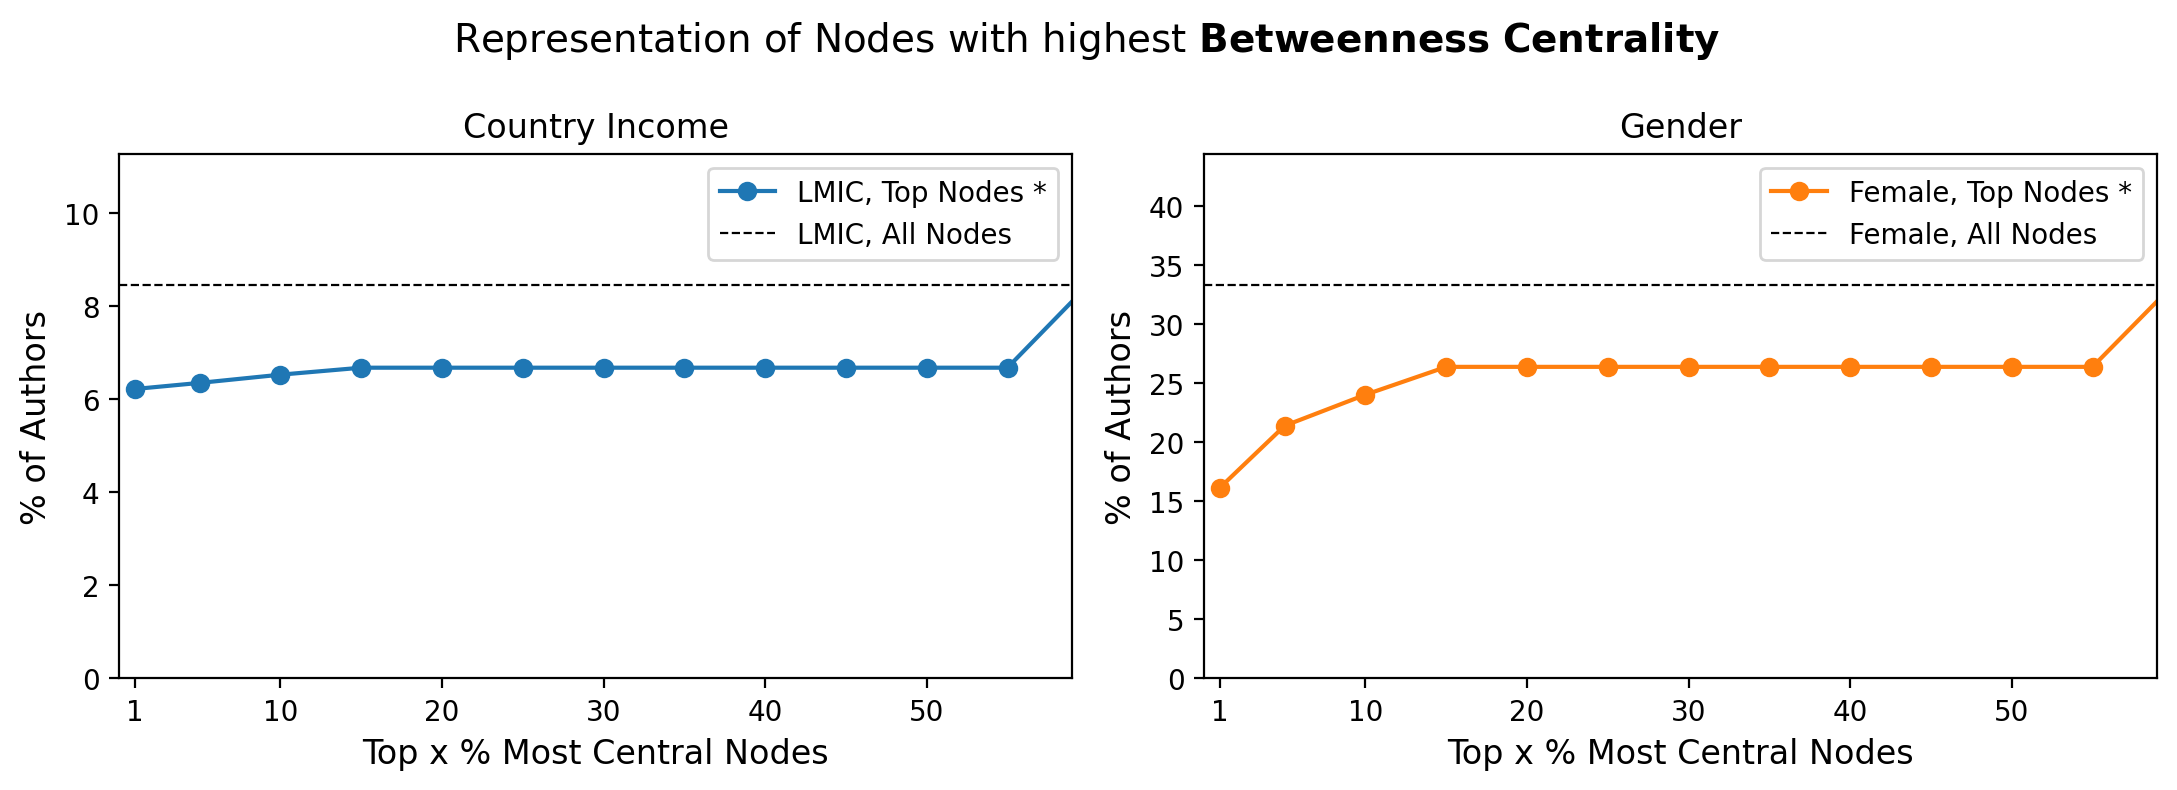

In [203]:
centralities = dict(zip(['rank_dc', 'rank_cc', 'rank_bc'],
                        ['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality']))

# iterate over the three centralities, dict
for key, centrality in centralities.items():
    
    lmic_means, th_lmic, female_means, th_female = get_top_x_percentile(key)

    tops = [0,4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,89,94,99]

    # limit lmic_means to the idxs in tops, transform into percentages
    lmic_means = [lmic_means[t]*100 for t in tops]
    female_means = [female_means[t]*100 for t in tops]
    
    xx = [t+1 for t in tops]
    plt.style.use('default')
    # figure with two plots
    fig, axs = plt.subplots(1,2, figsize=(11,4))
    # line plot
    axs[0].plot(xx, lmic_means, marker='o', label='LMIC, Top Nodes *', color='tab:blue')
    axs[1].plot(xx, female_means, marker='o', label='Female, Top Nodes *', color='tab:orange')

    # set labels
    axs[0].set_xlabel('Top x % Most Central Nodes', fontsize=12)
    axs[1].set_xlabel('Top x % Most Central Nodes', fontsize=12)

    axs[0].set_ylabel('% of Authors', fontsize=12)
    axs[1].set_ylabel('% of Authors', fontsize=12)

    # horizontal line for the average
    axs[0].axhline(y=avg_lmic, color='black', linestyle='--', linewidth=.8, label='LMIC, All Nodes')
    axs[1].axhline(y=avg_female, color='black', linestyle='--',linewidth=.8, label='Female, All Nodes')

    # set limits
    axs[0].set_ylim(0, avg_lmic*4/3)
    axs[1].set_ylim(0, avg_female*4/3)

    # add legend
    axs[0].legend(fontsize=10)
    axs[1].legend(fontsize=10)

    # set titles
    axs[0].set_title('Country Income', fontsize=12)
    axs[1].set_title('Gender', fontsize=12)

    # set xticks to start at 1
    axs[0].set_xticks(xx[::2])
    axs[1].set_xticks(xx[::2])
    
    # set limits
    axs[0].set_xlim(0, th_lmic+1)
    axs[1].set_xlim(0, th_female+1)

    # add supertitle
    # split the string with two words into two strings
    centrality_1 = centrality.split(' ')[0]
    centrality_2 = centrality.split(' ')[1]

    plt.suptitle(fr"Representation of Nodes with highest $\mathbf{{{centrality_1}}}$ $\mathbf{{{centrality_2}}}$", 
                 fontsize=14)

    plt.tight_layout()

    plt.show()

    # save figure
    fig.savefig(f'results/centrality_{key}.png', dpi=600)
